In [1]:
import numpy as np
import librosa
import soundfile as sf
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, normalize, MinMaxScaler
from sklearn.metrics import classification_report

In [2]:
import tensorflow as tf
from models import build_model2, cnn_model

In [67]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
data_dir = "./Music Genre Classification/"      
data_dir2 = "./Data copy/genres_original/"      

In [5]:
class FeatureExtractor():
    def __init__(self, datadir ,n_mfccs=13, n_fft=1024, hop_length=512, n_splits=10, hop=2):
        self.n_mfccs = n_mfccs
        self.hop_length = hop_length
        self.MFCCs = []
        self.labels = []
        self.datadir = datadir
        self.hop =  hop
        self.n_fft = n_fft
        self.n_splits = n_splits
    
    def extract_features(self):
        for path, subdirs, files in os.walk(self.datadir):
            for file in files:
                filepath = os.path.join(path, file)
                if file.endswith(".wav"):
                    try:
                        audio, sr = sf.read(filepath)
                        filepathList = filepath.split('/')
                        duration = int(audio.shape[0] / sr)
                        frame = int(duration / self.n_splits)
                        for i in range(0, duration, self.hop):
                            
                            MFCC = librosa.feature.mfcc(y=audio[i*sr: (i+frame)*sr], n_mfcc=self.n_mfccs, n_fft=self.n_fft, hop_length=self.hop_length)
                            if MFCC.shape != (13, 130): continue
                            genre = filepathList[-2]
                            self.MFCCs.append(MFCC)
                            self.labels.append(genre)        
                    except Exception as e:
                        print("Error encountered while parsing file: ", filepath)
                        print(e)
                        continue

In [6]:
data_extractor = FeatureExtractor(data_dir)
data_extractor.extract_features()

Error encountered while parsing file:  ./Music Genre Classification/Train/jazz/jazz.00054.wav
Error opening './Music Genre Classification/Train/jazz/jazz.00054.wav': Format not recognised.


In [7]:
data_extractor.MFCCs[-1].shape

(13, 130)

In [8]:
music_avg_mfccs = {genre: [] for genre in set(data_extractor.labels)}
for i in range(len(data_extractor.labels)):
    avg_mfccs = np.mean(data_extractor.MFCCs[i], axis=1)
    music_avg_mfccs[data_extractor.labels[i]].append(avg_mfccs)

In [9]:
music_avg_mfccs.keys()

dict_keys(['rock', 'pop', 'metal', 'reggae', 'classical', 'jazz', 'hiphop', 'disco', 'blues', 'country'])

In [10]:
X = [music_avg_mfccs[genre] for genre in music_avg_mfccs.keys()]
genres = music_avg_mfccs.keys()

In [11]:
mfccs_dict = {i: [] for i in range(1, data_extractor.n_mfccs+1)}
for i in range(len(genres)):
    test = np.array(X[i])
    for num in range(1, data_extractor.n_mfccs+1):
        mfccs_dict[num].append(test[:, (num-1)])

In [ ]:
plt.boxplot(mfccs_dict[1], patch_artist=True)
plt.xticks([i for i in range(1, len(genres)+1)], genres)

In [ ]:
plt.boxplot(mfccs_dict[2], patch_artist=True)
plt.xticks([i for i in range(1, len(genres)+1)], genres)

In [ ]:
plt.boxplot(mfccs_dict[3], patch_artist=True)
plt.xticks([i for i in range(1, len(genres)+1)], genres)

In [ ]:
plt.boxplot(mfccs_dict[4], patch_artist=True)
plt.xticks([i for i in range(1, len(genres)+1)], genres)

In [ ]:
plt.boxplot(mfccs_dict[5], patch_artist=True)
plt.xticks([i for i in range(1, len(genres)+1)], genres)

In [ ]:
plt.boxplot(mfccs_dict[6], patch_artist=True)
plt.xticks([i for i in range(1, len(genres)+1)], genres)

In [ ]:
plt.boxplot(mfccs_dict[7], patch_artist=True)
plt.xticks([i for i in range(1, len(genres)+1)], genres)

In [ ]:
plt.boxplot(mfccs_dict[8], patch_artist=True)
plt.xticks([i for i in range(1, len(genres)+1)], genres)

In [ ]:
plt.boxplot(mfccs_dict[9], patch_artist=True)
plt.xticks([i for i in range(1, len(genres)+1)], genres)

In [ ]:
plt.boxplot(mfccs_dict[10], patch_artist=True)
plt.xticks([i for i in range(1, len(genres)+1)], genres)

In [12]:
music_avg_mfccs['rock'][0].shape

(13,)

In [13]:
def build_model(input_shape, num_classes):
    
    
    model = Sequential([
        Dense(256, activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l2(0.001)),
        Dropout(0.3),
        Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        Dropout(0.3),
        Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        Dense(num_classes, activation='softmax')
    ])
    
    return model
    

In [68]:
# CNN model
def cnn_model(input_shape, num_classes):
    model_cnn = Sequential()

    # 1st conv layer
    model_cnn.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model_cnn.add(MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model_cnn.add(BatchNormalization())


    # 2nd conv layer
    model_cnn.add(Conv2D(64, (3, 3), activation='relu',kernel_initializer='he_uniform',kernel_regularizer=regularizers.l2(0.0001)))
    model_cnn.add(MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model_cnn.add(BatchNormalization())
    model_cnn.add(Dropout(0.3))

    # 3rd conv layer
    model_cnn.add(Conv2D(128, (2, 2), activation='relu',kernel_initializer='he_uniform',kernel_regularizer=regularizers.l2(0.0001)))
    model_cnn.add(MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model_cnn.add(BatchNormalization())
    model_cnn.add(Dropout(0.3))

    # flatten output and feed it into dense layer
    model_cnn.add(Flatten())
    model_cnn.add(Dense(128, activation='relu',kernel_initializer='he_uniform',kernel_regularizer=regularizers.l2(0.0001)))
    model_cnn.add(BatchNormalization())
    model_cnn.add(Dropout(0.3))

    # output layer
    model_cnn.add(Dense(num_classes, activation='softmax'))
    
    return model_cnn

In [14]:
label_encoder = LabelEncoder()
label_encoder.fit(data_extractor.labels)

LabelEncoder()

In [15]:
ANN = build_model((1, 13)
                , 10)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
ANN.compile(loss=CategoricalCrossentropy(), optimizer='adam', metrics=['accuracy'])

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
training_data = []
training_labels = []
for genre in music_avg_mfccs.keys():
    for i in range(len(music_avg_mfccs[genre])):
        training_data.append(music_avg_mfccs[genre][i])
        training_labels.append(label_encoder.transform([genre])[0])
        
training_data = np.array(training_data)
training_labels = np.array(training_labels)

In [17]:
scaler = MinMaxScaler(feature_range=(-1, 1))
normalized_training_data = scaler.fit_transform(training_data)

In [18]:
training_labels = to_categorical(training_labels)
training_labels = (training_labels[:, np.newaxis, :])
normalized_training_data = (normalized_training_data[:, np.newaxis, :])

In [19]:
X_train, X_test, y_train, y_test = train_test_split(normalized_training_data, training_labels, test_size=0.2)

In [20]:
training_labels.shape
y_train.shape

(8892, 1, 10)

In [ ]:
ANN.fit(X_train, y_train, epochs=100, validation_split=0.3,)

In [336]:
ANN.evaluate(X_test, y_test)

87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step - accuracy: 0.7877 - loss: 0.9295


[0.9276933073997498, 0.786796510219574]

In [ ]:
# ANN.save('model4.keras')

In [21]:
ANN.load_weights('model5.keras')
ANN.evaluate(X_test, y_test, verbose=2)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 - 0s - 3ms/step - accuracy: 0.8849 - loss: 0.7054


[0.7053617238998413, 0.8848921060562134]

In [22]:
y_predict_categorical = ANN.predict(X_test)
y_predict = y_predict_categorical.reshape((1, len(X_test), 10))[0]
y_test_reshaped = y_test.reshape((1, len(X_test), 10))[0]

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step


In [23]:
y_predict = np.argmax(y_predict, axis=1)
y_test_reshaped = np.argmax(y_test_reshaped, axis=1)

In [24]:
print(classification_report(y_test_reshaped, y_predict))

              precision    recall  f1-score   support

           0       0.88      0.92      0.90       224
           1       0.95      0.96      0.96       224
           2       0.86      0.84      0.85       219
           3       0.83      0.85      0.84       232
           4       0.83      0.85      0.84       219
           5       0.92      0.90      0.91       220
           6       0.93      0.91      0.92       235
           7       0.89      0.92      0.90       224
           8       0.89      0.87      0.88       201
           9       0.87      0.81      0.84       226

    accuracy                           0.88      2224
   macro avg       0.89      0.88      0.88      2224
weighted avg       0.89      0.88      0.88      2224



In [25]:
label_encoder.transform(['classical', 'blues', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock'])

array([1, 0, 2, 3, 4, 5, 6, 7, 8, 9])

In [79]:
class ModelPredictior():
    def __init__(self, model_path, input_shape, num_classes, n_mfccs=13, n_fft=1024, hop_length=512):
        # model path for buiding model
        self.model_path = model_path
        self.input_shape = input_shape
        self.n_mfccs = n_mfccs
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.num_classes = num_classes
        
    # Build DNN
    def build_dnn_model(self):
        model = build_model(self.input_shape, self.num_classes)
        return model
    
    # Build CNN
    def build_cnn_model(self):
        model = cnn_model(self.input_shape, self.num_classes)
        return model
    
    def predict(self, filepath, n_splits=10, hop=2):
        # Load File path and model weights
        try:
            # Load song
            audio, sr = sf.read(filepath)
            # Calulate duration
            duration = int(audio.shape[0] / sr)
            # Window size for spliting the song into smaller bits
            frame = int(duration / n_splits)
            # build and load model weights
            model = self.build_dnn_model()
            model.load_weights(self.model_path)
        except Exception as e:
            return
        
        # cache genre predictions
        genre_predictions = {}
 
        for i in range(0, duration, hop):
            # Extract MFCC of a window
            MFCC = librosa.feature.mfcc(y=audio[i*sr: (i+frame)*sr], n_mfcc=self.n_mfccs, n_fft=self.n_fft, hop_length=self.hop_length)
            # Calculate Mean MFCC across time axis
            MFCC = np.mean(MFCC, axis=1)
            # Add an axis for giving model as a batch size of 1
            MFCC = MFCC[np.newaxis, :]
            # scale model using Min Max scaler using all ready used in training
            MFCC = scaler.transform(MFCC)
            # predict
            prediction = model.predict(MFCC,  verbose=0)
            prediction = np.argmax(prediction, axis=1)
            genre = label_encoder.inverse_transform(prediction)
            # update frequency of genre predicted
            genre_predictions[genre[0]] = genre_predictions.get(genre[0], 0) + 1
    
        return genre_predictions
    
    
    def cnn_predict(self, filepath, n_splits=10, hop=2):
        try:
            # Load song
            audio, sr = sf.read(filepath)
            # Calulate duration
            duration = int(audio.shape[0] / sr)
            # Window size for spliting the song into smaller bits
            frame = int(duration / n_splits)
            # build and load model weights
            model = self.build_cnn_model()
            model.load_weights(self.model_path)
        except Exception as e:
            print(e)
            return
        
        
        genre_predictions = {}
        for i in range(0, duration, hop):
            try:
                # Extract model
                MFCC = librosa.feature.mfcc(y=audio[i*sr: (i+frame)*sr], n_mfcc=self.n_mfccs, n_fft=self.n_fft, hop_length=self.hop_length)
                # add a axis at beginning for batch size and other axis for CNN num channels 
                MFCC = MFCC[np.newaxis, :, :, np.newaxis]
                # predict
                prediction = model.predict(MFCC,  verbose=0)
                prediction = np.argmax(prediction, axis=1)
                genre = label_encoder.inverse_transform(prediction)
                # update frequency of genre predicted
                genre_predictions[genre[0]] = genre_predictions.get(genre[0], 0) + 1
            except Exception as e:
                continue
        
        return genre_predictions
        

In [33]:
# DNN model predictor
predictore = ModelPredictior(model_path='model5.keras', input_shape=(13,), num_classes=10)

In [34]:
# Example How the return value looks like 
file_path = "./Music Genre Classification/Train/rock/rock.00023.wav"
predicted_genres = predictore.predict(file_path)
print(predicted_genres)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


{'rock': 12, 'classical': 1, 'jazz': 2}


In [35]:
# randomly sample 20 full-songs from the given data set
import random
test_files = []
n_samples = 20
for path, subdirs, files in os.walk(data_dir):
    try:
        random_files = random.sample(files, n_samples)
        for file in random_files:
            filepath = os.path.join(path, file)
            if file.endswith(".wav"):
                test_files.append(filepath)     
    except Exception as e:
        print(e)
        continue
                    

Sample larger than population or is negative
Sample larger than population or is negative


In [ ]:
# given a dictionary it gives max genre
def max_freq_genre(genres):
    max_freq = 0
    max_genre = ''
    for genre in genres.keys():
        if genres[genre] > max_freq:
            max_freq = genres[genre]
            max_genre = genre
    return max_genre

# for DNN predict the genre of entire by giving to the predictor
predictions = []
actual = []
for file in test_files:
    try:
        predicted_genres = predictore.predict(file)
        predictions.append(max_freq_genre(predicted_genres))
        actual.append(file.split("/")[-2])
    except Exception as e:
        print("------------------")

In [37]:
# Classification Report for DNN using the full-songs sampled
print(classification_report(actual, predictions))

              precision    recall  f1-score   support

       blues       1.00      0.95      0.97        20
   classical       1.00      1.00      1.00        20
     country       0.95      1.00      0.98        20
       disco       0.95      0.95      0.95        20
      hiphop       0.95      0.95      0.95        20
        jazz       1.00      1.00      1.00        20
       metal       0.95      1.00      0.98        20
         pop       0.95      0.95      0.95        20
      reggae       1.00      0.95      0.97        20
        rock       0.90      0.90      0.90        20

    accuracy                           0.96       200
   macro avg       0.97      0.97      0.96       200
weighted avg       0.97      0.96      0.96       200



In [39]:
cnn = cnn_model(input_shape=(13, 130, 1), num_classes=10)
cnn.summary()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_202"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 11, 128, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 6, 64, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 6, 64, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 4, 62, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 2, 31, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 2, 31, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_404 (Dropout)           │ (None, 2, 31, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 1, 30, 128)     │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 1, 15, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1, 15, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_405 (Dropout)           │ (None, 1, 15, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1920)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1010 (Dense)              │ (None, 128)            │       245,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_406 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1011 (Dense)              │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 300,298 (1.15 MB)

 Trainable params: 299,594 (1.14 MB)

 Non-trainable params: 704 (2.75 KB)

In [40]:
# Transform the Labels
y = label_encoder.transform(data_extractor.labels)
# Load the MFCCs Extracted
X = data_extractor.MFCCs
# split the data-set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# add the last dimension for CNN
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)


In [41]:
# One Hot Encode the labels
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
# compile
cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [48]:
cnn.fit(X_train, y_train, batch_size=128, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.3838 - loss: 2.0381 - val_accuracy: 0.2932 - val_loss: 4.0949
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.6129 - loss: 1.1656 - val_accuracy: 0.4897 - val_loss: 1.6605
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.6893 - loss: 0.9734 - val_accuracy: 0.6583 - val_loss: 1.0152
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.7208 - loss: 0.8570 - val_accuracy: 0.7415 - val_loss: 0.8281
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.7735 - loss: 0.7232 - val_accuracy: 0.6996 - val_loss: 0.9383
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.7975 - loss: 0.6585 - val_accuracy: 0.7540 - val_loss: 0.7588
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.8159 - loss: 0.6035 - val_accuracy: 0.7612 - val_loss: 0.7484
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.8385 - loss: 0.5436 - val_accuracy: 0.7608 - v

In [49]:
cnn.evaluate(X_test, y_test, verbose=2)

70/70 - 0s - 3ms/step - accuracy: 0.7945 - loss: 0.6463


[0.6462752819061279, 0.7945144176483154]

In [50]:
cnn.save('cnn_model.keras')

In [80]:
CNN_predictor = ModelPredictior(model_path='cnn_model.keras', input_shape=(13, 130, 1), num_classes=10)

In [81]:
file_path = "./Music Genre Classification/Train/blues/blues.00039.wav"

predicted_genres = CNN_predictor.cnn_predict(file_path)
print(predicted_genres)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


{'blues': 14}


2025-03-30 22:17:57.727834: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Matrix size-incompatible: In[0]: [1,1280], In[1]: [1920,128]
	 [[{{node sequential_205_1/dense_1016_1/MatMul}}]]


In [ ]:
def max_freq_genre(genres):
    max_freq = 0
    max_genre = ''
    for genre in genres.keys():
        if genres[genre] > max_freq:
            max_freq = genres[genre]
            max_genre = genre
    return max_genre

predictions = []
actual = []
for i, file in enumerate(test_files):
    try:
        predicted_genres = CNN_predictor.cnn_predict(file)
        predictions.append(max_freq_genre(predicted_genres))
        actual.append(file.split("/")[-2])
    except Exception as e:
        print(i)
        

In [83]:
print((classification_report(actual, predictions)))

              precision    recall  f1-score   support

                   0.00      0.00      0.00         0
       blues       0.80      1.00      0.89        20
   classical       1.00      1.00      1.00        20
     country       1.00      0.90      0.95        20
       disco       0.87      1.00      0.93        20
      hiphop       0.95      1.00      0.98        20
        jazz       1.00      1.00      1.00        20
       metal       1.00      0.70      0.82        20
         pop       1.00      0.90      0.95        20
      reggae       0.95      0.90      0.92        20
        rock       0.86      0.90      0.88        20

    accuracy                           0.93       200
   macro avg       0.86      0.85      0.85       200
weighted avg       0.94      0.93      0.93       200



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

blues


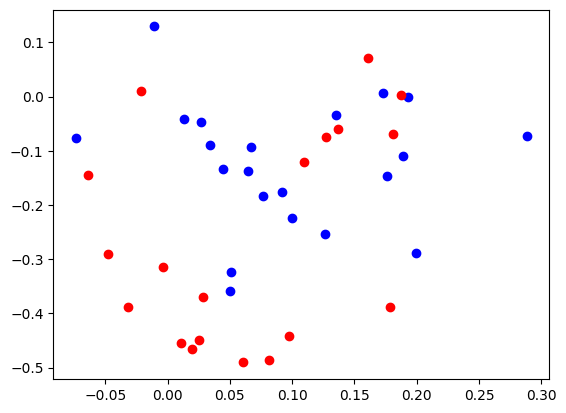

In [453]:
import matplotlib.pyplot as plt

genre = 'blues'
print(genre)
for i in range (0, 40):
    if i > 9:
        file_name = f"./Data copy/genres_original/{genre}/{genre}.000{i}.wav"
    else : 
        file_name = f"./Data copy/genres_original/{genre}/{genre}.0000{i}.wav"
    
    audio, sr = sf.read(file_name)
    MFCC = librosa.feature.mfcc(y=audio, n_mfcc=data_extractor.n_mfccs, n_fft=data_extractor.n_fft, hop_length=data_extractor.hop_length)
    MFCC = np.mean(MFCC, axis=1)
    MFCC = scaler.transform(MFCC[np.newaxis, :])
    if i > 20:
        plt.scatter(MFCC[0][1], MFCC[0][12], marker='o', c='red')
    else:
        plt.scatter(MFCC[0][1], MFCC[0][12], marker='o', c='blue')
    